# UPSC Essay Evaluation with LangGraph

This notebook demonstrates an automated essay evaluation system using LangGraph. The workflow evaluates essays across three parallel dimensions:

1. **Clarity of Thought (COT)** - Evaluates how clear and coherent the ideas are presented
2. **Depth of Analysis (DOA)** - Assesses the depth and quality of analysis in the essay
3. **Grammar and Structure (GS)** - Checks grammar, spelling, and overall structure

Each evaluation node provides:
- Detailed text feedback
- A score from 0-10

Finally, a **Final Evaluation Node** combines all feedback and calculates an overall average score.

The graph uses parallel execution for efficiency, running all three evaluations simultaneously before aggregating results.

In [1]:
# input - runs scored, balls played, 4s hit, 6s hit
# output - runs in boundary %, balls per boundry, strike rate

#       ------> clarity of thought (COT) ----------> Text feedback + Score (0-10) 
# START ------> Depth of Analysis (DOA) -----------> Text feedback + Score (0-10) --------> Final Evaluation Node (Summarized feedback + Overall Average Score) --------> END
#       ------> Grammar and Spelling (GS) ---------> Text feedback + Score (0-10) 

In [17]:
from langgraph.graph import StateGraph, START, END  
from typing import TypedDict, Annotated
import operator
from pydantic import BaseModel, Field
from euriai.langchain import create_chat_model
from dotenv import load_dotenv
import os
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("key")  # Retrieve the API key from environment variables

In [18]:
chat_model = create_chat_model(
    api_key=api_key,
    model="gpt-4.1-nano",
    temperature=0.7
)

In [19]:
essay = """The cow is a gentle and useful domestic animal found in many parts of the world. Known for its calm nature and friendly behavior, the cow has lived alongside humans for thousands of years. It plays an important role in agriculture, where it helps farmers by providing milk, manure, and even assistance in farming activities in some regions.
Cows are best known for the milk they produce, which is used to make butter, cheese, yogurt, and many other dairy products. This makes them a valuable source of nutrition for people of all ages. Their dung is also useful, as it can be used as natural fertilizer to enrich the soil, improving crop growth without harmful chemicals.
In addition to their practical benefits, cows are also respected in many cultures for their peaceful nature and symbolic importance. They are often associated with kindness, nourishment, and the environment. Overall, the cow is a helpful, gentle, and important animal that contributes greatly to both human life and the ecosystem."""

class EssayEvaluation(BaseModel):
    feedback: str = Field(description="Short Feedback on the essay.")
    score: float = Field(description="Overall score of the essay on a scale of 0 to 10.", ge=0, le=10)

structured_chat_model = chat_model.with_structured_output(EssayEvaluation)

prompt = f"Evaluate the language quality of the following essay and provide feedback and a score out of 10:\n\nEssay: {essay}"

output = structured_chat_model.invoke(prompt)

print("Feedback:", output.feedback)
print("Score:", output.score)

Feedback: The essay is well-structured and clearly explains the significance of cows in human life and culture. The language is straightforward and appropriate for a general audience, with good use of descriptive terms. However, it could be enhanced with more varied sentence structures and some additional details to deepen the analysis. Overall, it effectively communicates its message with clarity and simplicity.
Score: 7.5


In [ ]:
class UPSCState(TypedDict):
    essay_text: str
    cot_feedback: str
    doa_feedback: str
    gs_feedback: str
    
    # Annotated: A typing feature that attaches METADATA to types
    # Syntax: Annotated[ActualType, metadata1, metadata2, ...]
    # 
    # Annotated[list[int], operator.add] means:
    # - ActualType: list[int] - a list of integers (scores from each evaluation node)
    # - Metadata: operator.add - tells LangGraph HOW to merge values from parallel nodes
    # 
    # Without Annotated: Node updates would OVERWRITE each other
    #   Node1: {"scores": [5]} → Node2: {"scores": [7]} → Result: [7] ❌ (lost first score!)
    # 
    # With Annotated[list[int], operator.add]: Values ACCUMULATE using the + operator
    #   Node1: {"scores": [5]} → Node2: {"scores": [7]} → Result: [5, 7] ✅ (both preserved!)

    # Annotated[list[int], operator.add] means:
    # - This is a list of integers (scores from each evaluation node)
    # - operator.add tells LangGraph to APPEND new scores to the list when multiple nodes update it
    # - Instead of overwriting, it accumulates scores: [score1] + [score2] + [score3] = [score1, score2, score3]

    # For LangGraph reducers
    # messages: Annotated[list[str], operator.add]  # Accumulate messages
    # counter: Annotated[int, lambda x, y: x + y]   # Sum integers

    # Key Point: Annotated doesn't change the runtime type - individual_scores is still just a list[int]. 
    # The metadata is used by frameworks like LangGraph to decide how to merge values from parallel nodes.
    
    individual_scores: Annotated[list[int], operator.add]

    overall_feedback: str
    average_score: float


In [21]:
def evaluate_cot(state: UPSCState):
    prompt = f"Evaluate the clarity of thought in the following essay and provide feedback and a score out of 10:\n\nEssay: {state['essay_text']}"
    output = structured_chat_model.invoke(prompt)
    return {"cot_feedback": output.feedback, "individual_scores": [output.score]}

def evaluate_doa(state: UPSCState):
    prompt = f"Evaluate the depth of analysis in the following essay and provide feedback and a score out of 10:\n\nEssay: {state['essay_text']}"
    output = structured_chat_model.invoke(prompt)
    return {"doa_feedback": output.feedback, "individual_scores": [output.score]}

def evaluate_gs(state: UPSCState):
    prompt = f"Evaluate the grammar and structure in the following essay and provide feedback and a score out of 10:\n\nEssay: {state['essay_text']}"
    output = structured_chat_model.invoke(prompt)
    return {"gs_feedback": output.feedback, "individual_scores": [output.score]}

def final_evaluation(state: UPSCState):
    ## overall_feedback
    prompt = f"Based on the following feedbacks, provide a final summarized feedback :\n\nClarity of Thought Feedback: {state['cot_feedback']}\nDepth of Analysis Feedback: {state['doa_feedback']}\nGrammar and Structure Feedback: {state['gs_feedback']}"
    overall_feedback = chat_model.invoke(prompt).content
    ## avg score calculation
    individual_scores = state['individual_scores']
    average_score = sum(individual_scores) / len(individual_scores) if individual_scores else 0

    return {"overall_feedback": overall_feedback, "average_score": average_score}

In [25]:
graph = StateGraph(UPSCState)

graph.add_node("evaluatecot", evaluate_cot)
graph.add_node("evaluatedoa", evaluate_doa)
graph.add_node("evaluategs", evaluate_gs)
graph.add_node("finalevaluation", final_evaluation)

graph.add_edge(START, "evaluatecot")
graph.add_edge(START, "evaluatedoa")
graph.add_edge(START, "evaluategs")
graph.add_edge("evaluatecot", "finalevaluation")
graph.add_edge("evaluatedoa", "finalevaluation")
graph.add_edge("evaluategs", "finalevaluation")
graph.add_edge("finalevaluation", END)

workflow = graph.compile()

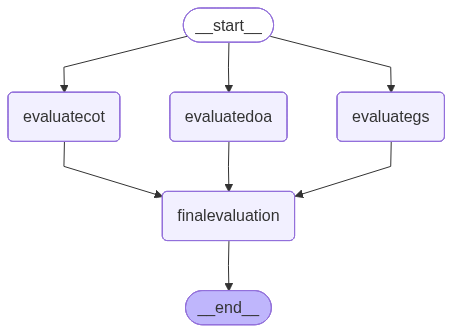

In [33]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [26]:
initial_state = {
    "essay_text": essay
}

final_state = workflow.invoke(initial_state)  

In [32]:
for i, j in final_state.items():
    print(f"{i}: {j}")
    print("==========================================================================")

essay_text: The cow is a gentle and useful domestic animal found in many parts of the world. Known for its calm nature and friendly behavior, the cow has lived alongside humans for thousands of years. It plays an important role in agriculture, where it helps farmers by providing milk, manure, and even assistance in farming activities in some regions.
Cows are best known for the milk they produce, which is used to make butter, cheese, yogurt, and many other dairy products. This makes them a valuable source of nutrition for people of all ages. Their dung is also useful, as it can be used as natural fertilizer to enrich the soil, improving crop growth without harmful chemicals.
In addition to their practical benefits, cows are also respected in many cultures for their peaceful nature and symbolic importance. They are often associated with kindness, nourishment, and the environment. Overall, the cow is a helpful, gentle, and important animal that contributes greatly to both human life and 